In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Load Dataset

In [2]:
force = False
training_data = torchvision.datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = torchvision.datasets.MNIST('data',train=False,transform=ToTensor())

train_dataloader = DataLoader(training_data,batch_size=128,drop_last=True)
test_dataloader = DataLoader(test_data,batch_size=128,drop_last=True)
print_shape = lambda X,y: print(f"Shape of X [N, C, H, W]: {X.shape}\n"
                                f"Shape of y: {y.shape} {y.dtype}")

print_shape(*next(iter(train_dataloader)))
print(f"steps per epoch = {len(train_dataloader)}")
print_shape(*next(iter(test_dataloader)))
print(f"steps per epoch = {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
steps per epoch = 468
Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
steps per epoch = 78


In [3]:
def noising(X, noise_factor = 0.2):
    return torch.randn_like(X)*noise_factor + X

In [4]:
def visualize_rows(*rows,n=20):
    fig,axs = plt.subplots(len(rows),n,
                           figsize=(n,len(rows)))
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax_r,row in zip(axs,rows):
        for ax, img in zip(ax_r,row):
            ax.imshow(img,cmap='gray')
            
    plt.show()

torch.Size([128, 1, 28, 28])
tensor(0.) tensor(1.)
torch.Size([128])


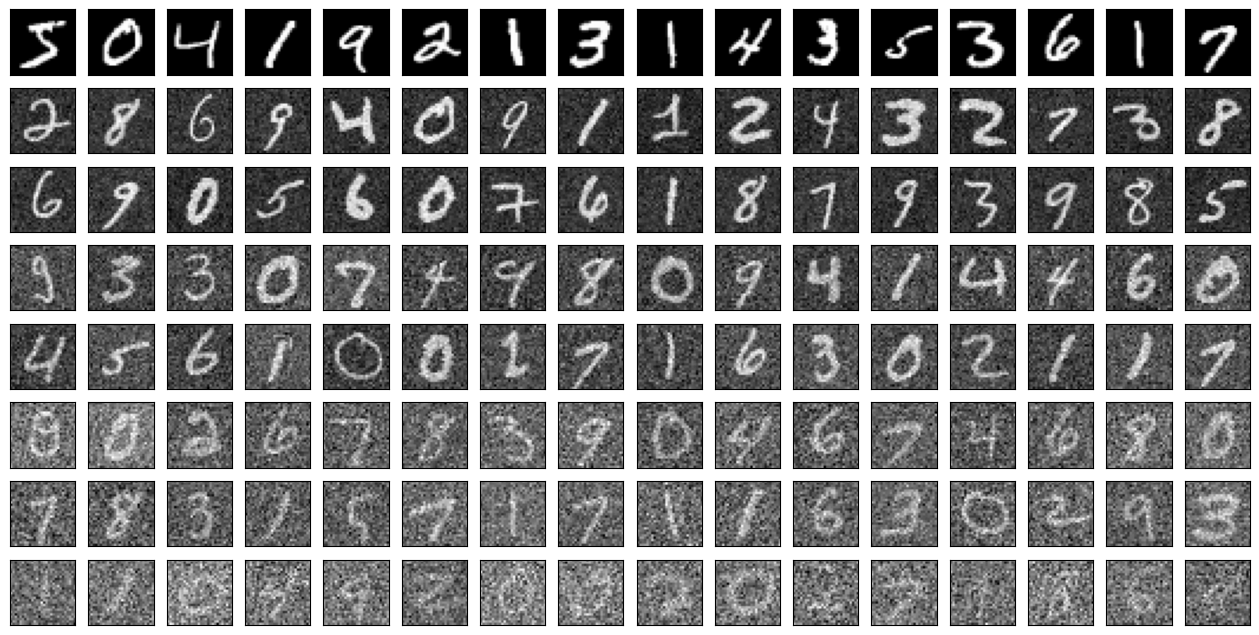

In [5]:
def fn():
    X,y = next(iter(train_dataloader))
    print(X.shape)
    print(X.min(),X.max()) # so it is normalize
    print(y.shape)
    X = X.squeeze().view(8,-1,28,28)
    for i,k in enumerate([0,0.1,0.1,0.2,0.2,0.4,0.4,0.8]):
        X[i,:] = noising(X[i,:] ,k)
    visualize_rows(*X,n=X.size(1))
fn()

### Model

In [6]:
class MNIST_Generator(nn.Module):
    def __init__(self,input_size,ngf=64,channel_num=1,num_classes=10) -> None:
        super(MNIST_Generator,self).__init__()
        self.latent_dim = input_size
        self.num_classes = num_classes
        # number of generator filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_size+num_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(ngf,channel_num, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Sigmoid()
        )
    
    def generate(self,y:torch.Tensor):
        batch_sz = y.size(0)
        noise = torch.randn((batch_sz,self.latent_dim),device=y.device.type)
        y = F.one_hot(y,num_classes=self.num_classes)
        noise = torch.cat((noise,y),dim=1) # conditioning
        return self.forward(noise)

    def forward(self,x):
        x = x.view(x.size(0),-1,1,1)
        x = self.decoder(x)
        return x

In [7]:
class MNIST_Discriminator(nn.Module):
    def __init__(self,num_classes=10):
        super(MNIST_Discriminator,self).__init__()
        self.num_classes = num_classes
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(288+num_classes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y):
        x = self.conv(x)
        x  = self.flatten(x)
        y = F.one_hot(y,self.num_classes)
        x = torch.cat((x,y),dim=1)
        x = self.linear_relu_stack(x)
        x = x.view(x.size(0), -1)
        return x

### Checkpoint

In [8]:
def load(model_ctor,optim_ctor,checkpoint_path):
    checkpoint = torch.load(checkpoint_path,map_location=device)
    model = model_ctor(**checkpoint['model_kwargs']).to(device)
    model.load_state_dict(checkpoint['model'])
    optimizer = optim_ctor(model.parameters(), **checkpoint['optim_kwargs'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model,optimizer,checkpoint['train_loss_hist']

def save_checkpoint(model,optimizer,train_loss_hist,
                    checkpoint_path,new_checkpoint=None):
    if new_checkpoint is None:
        new_checkpoint = checkpoint_path
    checkpoint = torch.load(checkpoint_path,map_location=device)
    new_checkpoint_values = {
        'model'             : model.state_dict(),
        'optimizer'         : optimizer.state_dict(),
        'train_loss_hist'   : train_loss_hist,
    }
    for k,v in new_checkpoint_values.items():
        checkpoint[k] = v
    torch.save(checkpoint,new_checkpoint)

In [9]:
import os
def init_generator(checkpoint_path,force_init = False):
    if not os.path.exists(checkpoint_path) or force_init:
        model_kwargs = {'input_size':3}
        optim_kwargs = {'lr':0.0005}
        model = MNIST_Generator(**model_kwargs).to(device)
        optimizer = torch.optim.Adam(model.parameters(), **optim_kwargs)
        torch.save({
            'model_kwargs'      : model_kwargs,
            'optim_kwargs'      : optim_kwargs,
            'optimizer'         : optimizer.state_dict(),
            'model'             : model.state_dict(),
            'train_loss_hist'   : [],
        },checkpoint_path)

def init_discriminator(checkpoint_path,force_init = False):
    if not os.path.exists(checkpoint_path) or force_init:
        model_kwargs = {}
        optim_kwargs = {'lr':0.0005}
        model = MNIST_Discriminator(**model_kwargs).to(device)
        optimizer = torch.optim.Adam(model.parameters(), **optim_kwargs)
        torch.save({
            'model_kwargs'      : model_kwargs,
            'optim_kwargs'      : optim_kwargs,
            'optimizer'         : optimizer.state_dict(),
            'model'             : model.state_dict(),
            'train_loss_hist'   : [],
        },checkpoint_path)

In [10]:
generator_path = lambda n : f'./model_checkpoint/mnist_generator - {n}.pth'
discriminator_path = lambda n : f'./model_checkpoint/mnist_discriminator - {n}.pth'

In [11]:
def generate_all_n_plot(G:MNIST_Generator,n=10,device=device):
    with torch.no_grad():
        G.eval()
        y = torch.arange(0,10).view(1,-1).repeat(n,1).flatten().to(device)
        fake_X = G.generate(y)
        fake_X = fake_X.view(fake_X.size(0),28,28).cpu()
        fake_X = fake_X.view(-1,10,28,28)
        visualize_rows(*fake_X,n=10)

def discriminator_pass(D:MNIST_Discriminator,G:MNIST_Generator,real_X,real_y,criterion):
    device = real_X.device.type
    fake_X = G.generate(real_y)
    
    pred = D(real_X,real_y).flatten()
    y = torch.ones(real_X.size(0),device=device).flatten()
    d_loss = criterion(pred,y)
    
    pred = D(fake_X,real_y).flatten()
    
    y = torch.zeros(fake_X.size(0),device=device).flatten()
    d_loss += criterion(pred,y)
    
    return d_loss

def generator_pass(D:MNIST_Discriminator,G:MNIST_Generator,real_y,criterion):
    fake_X = G.generate(real_y)
    pred = D(fake_X,real_y).flatten()
    y = torch.ones_like(real_y).float()
    g_loss = criterion(pred,y)
    return g_loss

In [12]:
def fn():
    
    init_generator(generator_path(0),False)
    g_load = lambda: load(MNIST_Generator,optim.Adam,generator_path(0))
    generator,g_optimizer,g_train_loss_hist = g_load()
    save_checkpoint(generator,g_optimizer,g_train_loss_hist,generator_path(0))
    
    init_discriminator(discriminator_path(0),False)
    d_load = lambda: load(MNIST_Discriminator,optim.Adam,discriminator_path(0))
    discriminator,d_optimizer,d_train_loss_hist = d_load()
    save_checkpoint(discriminator,d_optimizer,d_train_loss_hist,discriminator_path(0))
    

    
    
    generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(0))
    discriminator,*_ = load(MNIST_Discriminator,optim.Adam,discriminator_path(0))
    generator.eval()
    discriminator.eval()
    
    X,y = next(iter(test_dataloader))
    X,y = X.to(device),y.to(device)
    
    g_loss_fn = nn.BCELoss()
    d_loss_fn = nn.BCELoss()
    
    g_loss = generator_pass(discriminator,generator,y,g_loss_fn)
    print(g_loss)
    d_loss = discriminator_pass(discriminator,generator,X,y,d_loss_fn)
    print(d_loss)
    
    del generator, discriminator
fn()

tensor(0.5568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.4085, device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
def update_gan(D:MNIST_Discriminator,G:MNIST_Generator,
               d_optim,g_optim,dataset):
    D.train()
    G.train()
    g_loss_fn = nn.BCELoss()
    d_loss_fn = nn.BCELoss()
    d_losses = []
    g_losses = []
    mean = lambda xs: torch.tensor(xs).float().mean().item()
    # for _,(X,y) in zip(range(10),dataset):
    for X,y in dataset:
        X,y = X.to(device),y.to(device)
        
        g_loss = generator_pass(D,G,y,g_loss_fn)
        G.zero_grad()
        g_loss.backward()
        g_optim.step()
        
        D.zero_grad()
        d_loss = discriminator_pass(D,G,X,y,d_loss_fn)
        d_loss.backward()
        d_optim.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    
    return mean(d_losses),mean(g_losses)

In [14]:
def plot_loss(d_train_loss_hist,g_train_loss_hist):
    plt.title(f'epoch {len(d_train_loss_hist)}')
    plt.plot(d_train_loss_hist,label='D loss')
    plt.plot(g_train_loss_hist,label='G loss')
    plt.legend()
    plt.show()

In [15]:
force = False
init_generator(generator_path(0),force)
init_discriminator(discriminator_path(0),force)

In [16]:
def train(start = 0, n = 1):
    from IPython import display

    init_generator(generator_path(start))
    init_discriminator(discriminator_path(start))
    
    g_load = lambda: load(MNIST_Generator,optim.Adam,generator_path(start))
    d_load = lambda: load(MNIST_Discriminator,optim.Adam,discriminator_path(start))
    
    generator,g_optimizer,g_train_loss_hist = g_load()
    discriminator,d_optimizer,d_train_loss_hist = d_load()
    
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    for i in range(1,n+1):
        d_loss,g_loss = update_gan(discriminator,generator,d_optimizer,g_optimizer,test_dataloader)
        
        d_train_loss_hist.append(d_loss)
        g_train_loss_hist.append(g_loss)
        display.clear_output()
        print(len(d_train_loss_hist))
        k = 50
        plot_loss(d_train_loss_hist[k:],g_train_loss_hist[k:])
        generate_all_n_plot(generator,2)
        if i % 25 == 0:
            save_checkpoint(generator,g_optimizer,g_train_loss_hist,generator_path(start),generator_path(start + i))
            save_checkpoint(discriminator,d_optimizer,d_train_loss_hist,discriminator_path(start),discriminator_path(start + i))
# train(start = 200, n = 100)

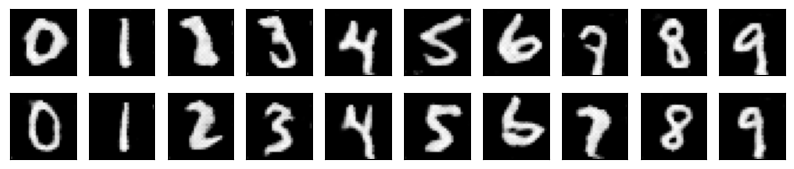

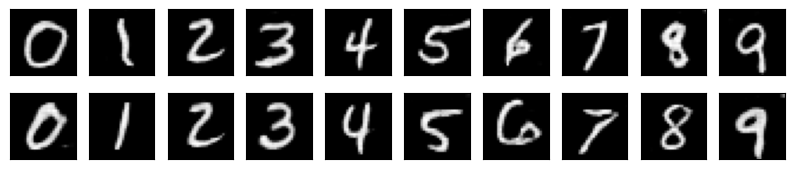

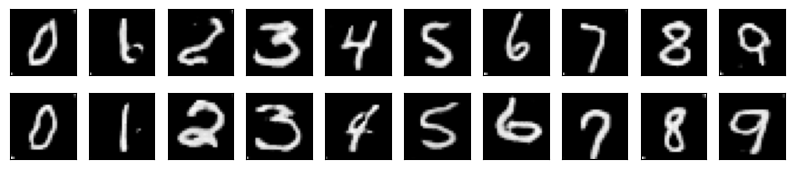

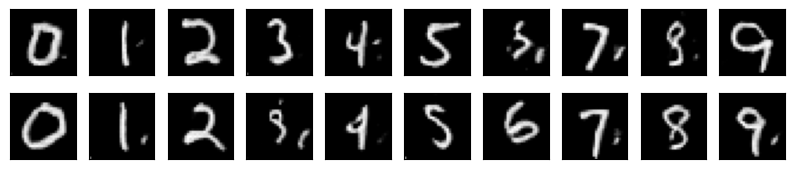

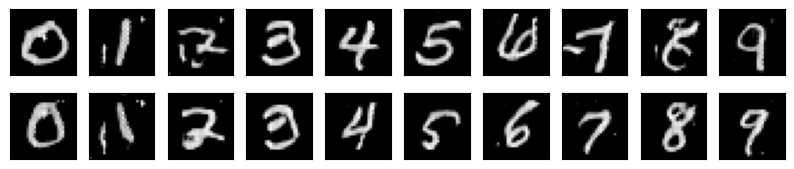

In [17]:
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(200))
generate_all_n_plot(generator,n = 2)
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(225))
generate_all_n_plot(generator,n = 2)
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(250))
generate_all_n_plot(generator,n = 2)
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(275))
generate_all_n_plot(generator,n = 2)
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(300))
generate_all_n_plot(generator,n = 2)

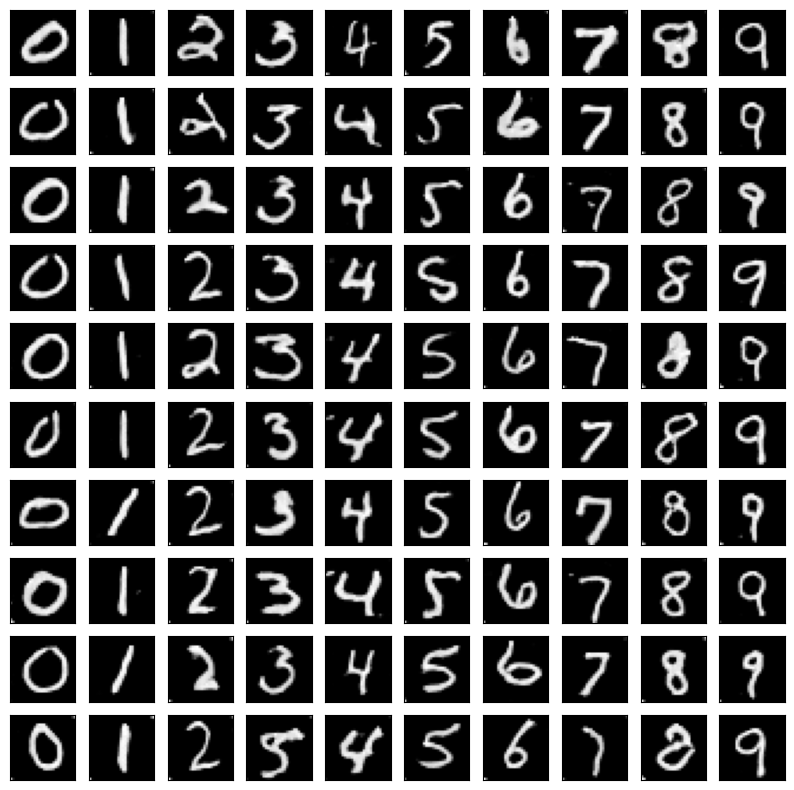

In [18]:
generator,*_ = load(MNIST_Generator,optim.Adam,generator_path(250))
generate_all_n_plot(generator,n = 10)